In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cymetric as cym

/home/scopatz/miniconda3/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/home/scopatz/miniconda3/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)
/home/scopatz/miniconda3/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.enrichment is not yet QA compliant.
  return f(*args, **kwds)


In [2]:
years = 250
startyear = 1960
tickstep = 25  # years
with cym.dbopen('{0}yr-cycamore.sqlite'.format(years)) as db:
    evaler = cym.Evaluator(db)
    agents = evaler.eval('Agents')
    timepower = evaler.eval('TimeSeriesPower')
    #blrx = evaler.eval('AgentState_Brightlite_ReactorFacilityInfo')
    cycarx = evaler.eval('AgentState_cycamore_ReactorInfo')

In [3]:
df = pd.merge(agents[['SimId', 'AgentId', 'Prototype']], timepower, on=['SimId', 'AgentId'])

In [4]:
totpower = df[['Prototype', 'Time', 'Value']].groupby(['Prototype', 'Time']).sum()
prototypes = totpower.index.levels[0]
x = totpower.loc[prototypes[0]]
x.rename(columns={'Value': prototypes[0]}, inplace=True)
x.reset_index(inplace=True)
for ptype in prototypes[1:]:
    col = totpower.loc[ptype]
    col.rename(columns={'Value': ptype}, inplace=True)
    col.reset_index(inplace=True)
    x = pd.merge(x, col, on=['Time'], how='outer')
x.fillna(0.0, inplace=True)
x.sort(columns=['Time'], inplace=True)

/home/scopatz/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


/home/scopatz/miniconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


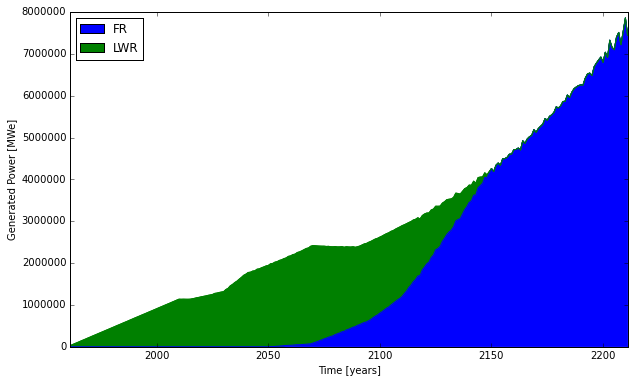

In [5]:
# manipulate x for plotting
newx = pd.DataFrame({'Time': x.Time.apply(lambda x: x//12) + startyear, 'LWR': x.LWR, 'FR': x.FR})
newx = newx.groupby('Time').sum()
newx.plot(kind='area', figsize=(10, 6))
plt.xlabel('Time [years]')
plt.ylabel('Generated Power [MWe]')
plt.savefig('total-genpower-cycamore.png', dpi=326)
newx.to_csv('total-genpower-cycamore.csv')

In [6]:
yearly = x[::12].copy()
yearly['Time'] = (yearly['Time'] / 12) + startyear
yearly['FR'] /= 1000
yearly['LWR'] /= 1000
yearly.to_csv('total-genpower-cycamore.csv')

In [7]:
lwrfr = agents[['AgentId', 'Prototype', 'EnterTime', 'ExitTime']]
mask = lwrfr['Prototype'] == 'FR'
mask = mask | (lwrfr['Prototype'] == 'LWR')
lwrfr = lwrfr[mask]
onoff = pd.merge(lwrfr, cycarx[['AgentId', 'power_cap']], on=['AgentId'], how='outer')
onoff.dropna(subset=['Prototype'], inplace=True)
# hack for blrx table
onoff['power_cap'][onoff['power_cap'].isnull() & (onoff['Prototype'] == 'LWR')] = 1000
onoff['power_cap'][onoff['power_cap'].isnull() & (onoff['Prototype'] == 'FR')] = 400

/home/scopatz/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/scopatz/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
on = onoff[['Prototype', 'EnterTime', 'power_cap']]
#on

/home/scopatz/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/scopatz/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


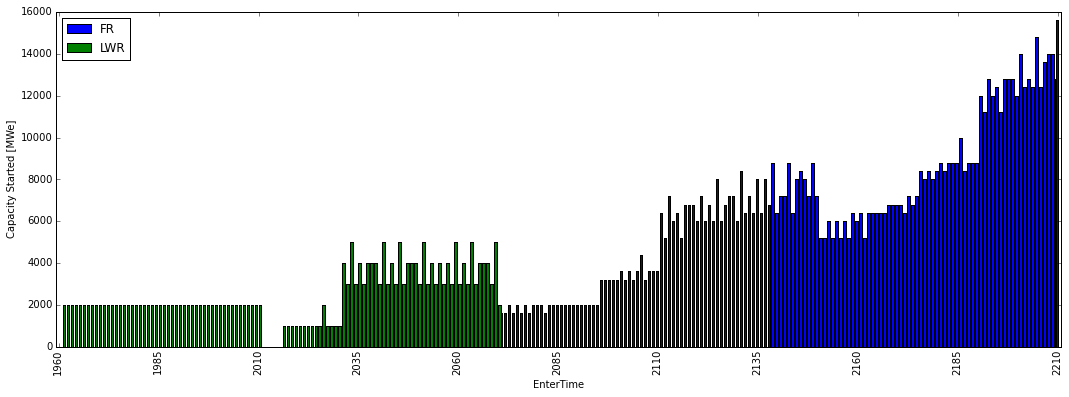

In [9]:
totpower = on.groupby(['Prototype', 'EnterTime']).sum()
prototypes = totpower.index.levels[0]
x = totpower.loc[prototypes[0]]
x.rename(columns={'power_cap': prototypes[0]}, inplace=True)
x.reset_index(inplace=True)
for ptype in prototypes[1:]:
    col = totpower.loc[ptype]
    col.rename(columns={'power_cap': ptype}, inplace=True)
    col.reset_index(inplace=True)
    x = pd.merge(x, col, on=['EnterTime'], how='outer')
x.fillna(0.0, inplace=True)
x.sort(columns=['EnterTime'], inplace=True)
x = pd.merge(x, pd.DataFrame({'EnterTime': range(0, years*12 + 1)}), on=['EnterTime'], how='outer')
x.fillna(0.0, inplace=True)
x.sort(columns=['EnterTime'], inplace=True)
x.plot(x='EnterTime', kind='bar', figsize=(18, 6), 
       #ylim=(0, 10000), 
       width=15)
plt.xticks(range(0, years*12 + 1, tickstep*12), range(startyear, startyear+years+1, tickstep))
plt.ylabel('Capacity Started [MWe]')
plt.savefig('capacity-started-cycamore.png', dpi=326, bbox_inches='tight')

In [10]:
yearly = x[::12].copy()
yearly['EnterTime'] = (yearly['EnterTime'] / 12) + startyear
yearly['FR'] /= 1000
yearly['LWR'] /= 1000
yearly.to_csv('capacity-started-cycamore.csv')

In [11]:
off = onoff[['Prototype', 'ExitTime', 'power_cap']]

/home/scopatz/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/scopatz/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


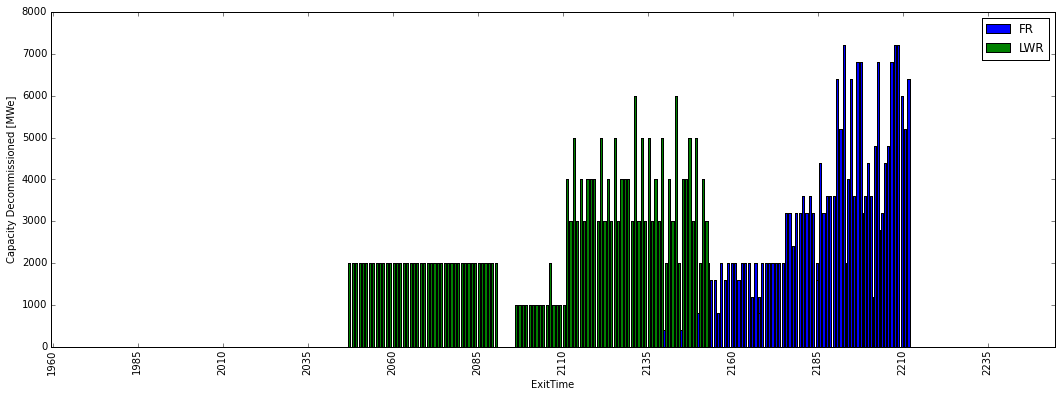

In [12]:
totpower = off.groupby(['Prototype', 'ExitTime']).sum()
prototypes = totpower.index.levels[0]
x = totpower.loc[prototypes[0]]
x.rename(columns={'power_cap': prototypes[0]}, inplace=True)
x.reset_index(inplace=True)
for ptype in prototypes[1:]:
    col = totpower.loc[ptype]
    col.rename(columns={'power_cap': ptype}, inplace=True)
    col.reset_index(inplace=True)
    x = pd.merge(x, col, on=['ExitTime'], how='outer')
x.fillna(0.0, inplace=True)
x.sort(columns=['ExitTime'], inplace=True)
x = x[:-1]  # remove false forced decomisioning at end of simulation
x = pd.merge(x, pd.DataFrame({'ExitTime': range(0, (years+44)*12 + 1)}), on=['ExitTime'], how='outer')
x.fillna(0.0, inplace=True)
x.sort(columns=['ExitTime'], inplace=True)
x.plot(x='ExitTime', kind='bar', figsize=(18, 6), 
       #ylim=(0, 10000), 
       width=15)
plt.xticks(range(0, (years+44)*12+1, tickstep*12), range(startyear, startyear+years+1+44, tickstep))
plt.ylabel('Capacity Decommissioned [MWe]')
plt.savefig('capacity-decomm-cycamore.png', dpi=326, bbox_inches='tight')
#x.to_csv('capacity-decomm-cycamore.csv')

In [13]:
yearly = x[::12].copy()
yearly['ExitTime'] = (yearly['ExitTime'] / 12) + startyear
yearly['FR'] /= 1000
yearly['LWR'] /= 1000
yearly.to_csv('capacity-decomm-cycamore.csv')

In [14]:
yearly = x[11::12].copy()
yearly['ExitTime'] = (yearly['ExitTime'] / 12) + startyear
yearly['FR'] /= 1000
yearly['LWR'] /= 1000
yearly.to_csv('capacity-decomm-cycamore-offset11.csv')